In [1]:
%load_ext autoreload
%autoreload 2

# general
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# custom
from reflectance import plotting

In [11]:
# read .img file
parameters_fp = Path("/Users/rt582/Downloads/parameters/parameters.img.hdr")
mix_fracs_fp = Path("/Users/rt582/Downloads/mixing_fractions/mixing_fractions.img.hdr")
hl_1_fp = Path("/Users/rt582/Downloads/sim_Rrs_wind_02_sunzen_20/sim_Rrs_wind_02_sunzen_20.img.hdr")

# open envi image files with spectral
from spectral import open_image, envi
parameters = open_image((parameters_fp))
mix_fracs = open_image((mix_fracs_fp))
hl_1 = open_image((hl_1_fp))
hl_1_vals = hl_1.load()

wvs = hl_1.bands.centers
SENSOR_RANGE = (450, 690)

In [12]:
param_vals = parameters.load()
mix_fracs_vals = mix_fracs.load()
print("param_vals.shape", param_vals.shape) # 2000 combinations of IOPs, 4 IOPs
print("mix_fracs_vals.shape", mix_fracs_vals.shape) # 6 Rb components, 3003 permutations
print("––––––")
print("hl_1.shape", hl_1.shape) # 2000 IOP combinations, 3003 permutations of Rb components, 230 wavelengths

param_vals.shape (2000, 4, 1)
mix_fracs_vals.shape (6, 3003, 1)
––––––
hl_1.shape (2000, 3003, 230)


## Visualising dataset

In [13]:
import plotly.express as px
import pandas as pd

param_vals_df = pd.DataFrame(np.squeeze(param_vals), columns=["chl", "aCDOM", "sand", "depth"])

fig = px.imshow(param_vals_df, aspect='auto', title="IOP values")
fig.update_traces(hovertemplate='value: %{z}')
fig.update_layout(
    title=dict(text="IOP values"),
    coloraxis_colorbar=dict(
        title="Value",
        titlefont=dict(size=12),
        tickfont=dict(size=8),
        )
)
fig.show()

In [14]:
fracs_vals_df = pd.DataFrame(np.squeeze(mix_fracs_vals).T, columns = ["algae", "coral", "mud", "octocoral", "sand", "seagrass"])
fig = px.imshow(fracs_vals_df.T, aspect='auto', title="IOP values")
fig.update_traces(hovertemplate='Rb: %{x} <br> value: %{z}')
fig.update_layout(
    title=dict(text="Rb mixing fractions"),
    coloraxis_colorbar=dict(
        title="Mixing Fraction",
        titlefont=dict(size=12),
        tickfont=dict(size=8),
        )
)
fig.show()

## Retrieving approximations of endmembers

In [15]:
num_endmembers = len(mix_fracs_vals)
num_samples = 50
iop_vals = np.array([0.05, 0.05, 1, 1], dtype=np.float32)
endmembers = ["algae", "coral", "mud", "octocoral", "sand", "seagrass"]

# create an array of spectra for each endmember
spectra = np.zeros((num_endmembers, num_samples, hl_1.shape[-1]))
for i in range(num_endmembers):
    Rbs = np.zeros(num_endmembers)
    Rbs[i] = 1
    iop_ind = np.where(np.all((np.squeeze(param_vals) == iop_vals), axis=1))
    Rb_ind = np.where(np.all((np.squeeze(mix_fracs_vals).T == Rbs), axis=1))
    normed_spectra = hl_1_vals[iop_ind[0], Rb_ind[0], :] / np.max(hl_1_vals[iop_ind[0], Rb_ind[0], :])
    # spectra[i] = hl_1_vals[iop_ind[0], Rb_ind[0], :]  # not normalised
    spectra[i] = normed_spectra
    

spectra_df = pd.DataFrame(spectra.reshape(-1,len(wvs)), columns=wvs)

rgb_colours = plotting.generate_spectra_color(spectra_df)

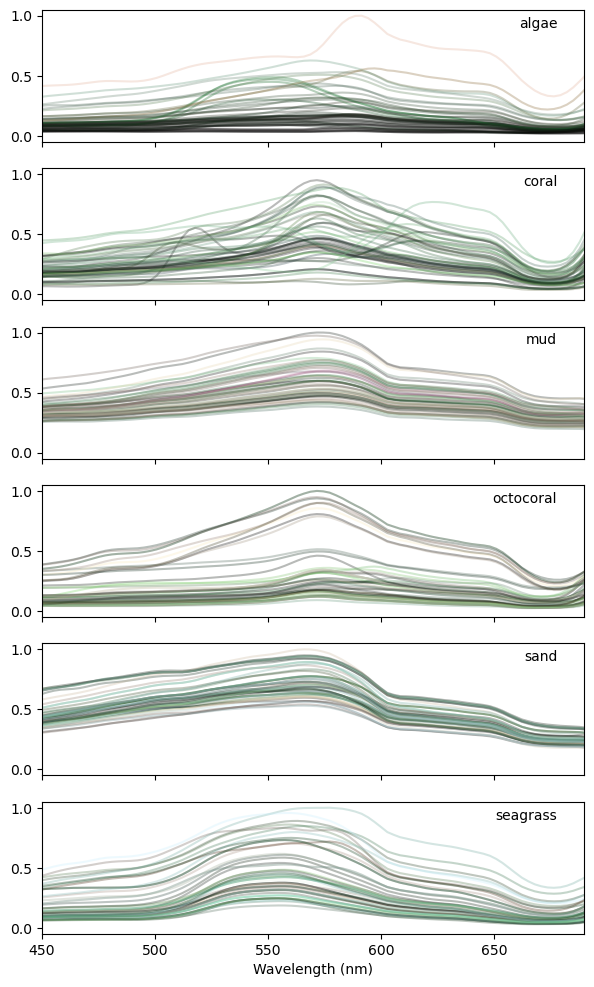

In [16]:
fig, ax = plt.subplots(num_endmembers, 1, figsize=(7, 2*num_endmembers), sharex=True, sharey=True)
for i in range(num_endmembers):
    for j in range(num_samples):
        ax[i].plot(wvs, spectra[i][j], c=rgb_colours[(i*j)+j], alpha=0.3);        
    # formatting
    ax[i].set_xlim(SENSOR_RANGE)
    ax[i].text(0.95, 0.95, f"{endmembers[i]}", transform=ax[i].transAxes, ha='right', va='top')
    
ax[-1].set_xlabel("Wavelength (nm)");

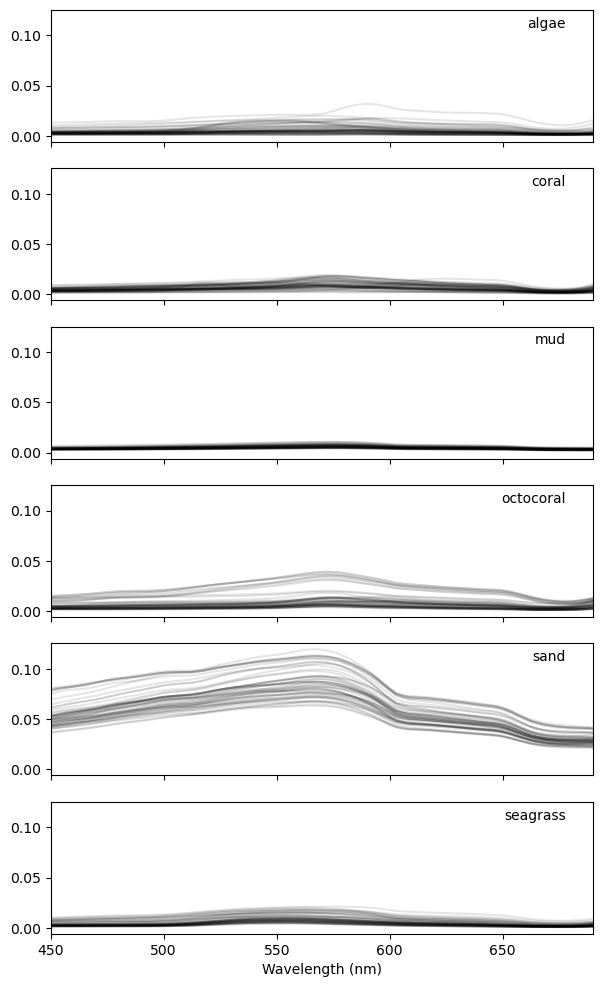

In [17]:

fig, ax = plt.subplots(num_endmembers, 1, figsize=(7, 2*num_endmembers), sharex=True, sharey=True)
for i in range(num_endmembers):
    Rbs = np.zeros(num_endmembers)
    Rbs[i] = 1
    iop_ind = np.where(np.all((np.squeeze(param_vals) == iop_vals), axis=1))
    Rb_ind = np.where(np.all((np.squeeze(mix_fracs_vals).T == Rbs), axis=1))
    ax[i].plot(wvs, hl_1_vals[iop_ind[0], Rb_ind[0], :].T, c="k", alpha=0.1);
    # formatting
    ax[i].set_xlim(SENSOR_RANGE)
    ax[i].text(0.95, 0.95, f"{endmembers[i]}", transform=ax[i].transAxes, ha='right', va='top')
    
ax[-1].set_xlabel("Wavelength (nm)");

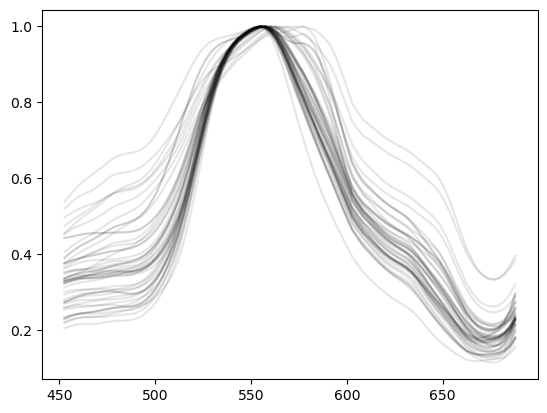

In [18]:
# normalise the spectra
spectra = hl_1_vals[iop_ind[0], Rb_ind[0], :]
spectra_df = pd.DataFrame(spectra, columns=wvs)
spectra_df = spectra_df.loc[:, SENSOR_RANGE[0]:SENSOR_RANGE[1]]
# normalise each row of spectra_df
norm_spectra_df = spectra_df.div(spectra_df.max(axis=1), axis=0)

plt.plot(norm_spectra_df.T, color="k", alpha=0.1);


## Dependence on parameters

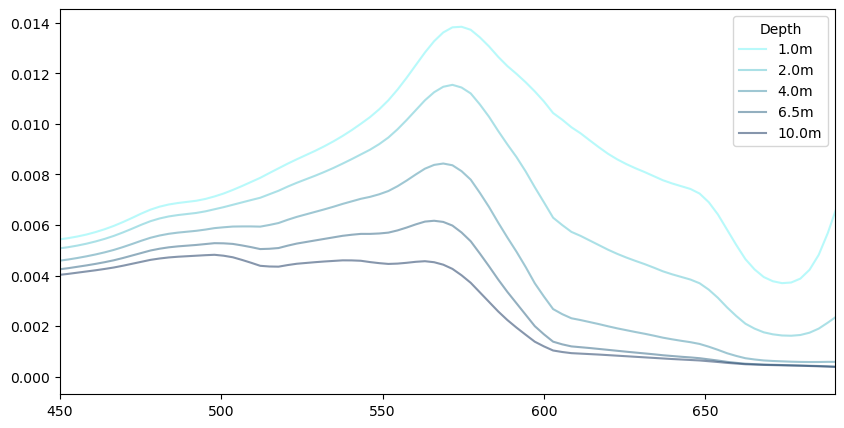

In [19]:
# plot mean of spectra for different depths
depths = np.unique(param_vals[:, 3])

num_endmembers = len(mix_fracs_vals)
chl_val = 0.05
aCDOM_val = 0.05
sand_val = 1

Rb_values = np.array([0, 0, 0, 1, 0, 0], dtype=np.float32)

start_hex = "#72F4F6"
end_hex = "#0f2e5a"
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list("custom", [start_hex, end_hex], N=len(depths))
# generate len(depths) colour hexes
colors = [cmap(i) for i in range(len(depths))]

plt.figure(figsize=(10, 5))
for d_i, d in enumerate(depths):
    iop_vals = np.array([chl_val, aCDOM_val, sand_val, d], dtype=np.float32)
    iop_ind = np.where(np.all((np.squeeze(param_vals) == iop_vals), axis=1))
    Rb_ind = np.where(np.all((np.squeeze(mix_fracs_vals).T == Rb_values), axis=1))
    # take a mean of the spectra
    spectrum = np.mean(hl_1_vals[iop_ind[0], Rb_ind[0], :], axis=0)
    
    plt.plot(wvs, spectrum, label=f"{d}m", alpha = 0.5, color=colors[d_i])
    plt.xlim(SENSOR_RANGE)
    
plt.legend(title="Depth");